In [33]:
%reload_ext autoreload
%autoreload 2

### 1. Split data into train, test

In [34]:
from datasets.german_credit import GermanCreditDataset
dataset = GermanCreditDataset()
X_train, y_train, X_test, _ = dataset.get_original_train_test_split()

[INFO] Dropped rows with NaN: 478 (kept 522)


e:\github_repositories\COLA\datasets\german_credit.py:88: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[self.target_name]


### 2. Build the pipeline and train the model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Define feature lists
numerical_features = ['Age', 'Credit amount', 'Duration']
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Step 1: Create the preprocessor
# Linear models require feature scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Step 2: Create the Logistic Regression classifier
lr_classifier = LogisticRegression(
    max_iter=1000,
    C=1.0,  # Inverse of regularization strength
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    solver='lbfgs'  # Suitable for small datasets
)

# Step 3: Create the Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lr_classifier)
])

# Step 4: Training
# Ensure categorical features are strings before fitting, as OneHotEncoder expects string-like input often
for c in categorical_features:
    X_train[c] = X_train[c].astype(str)
    X_test[c] = X_test[c].astype(str)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'Credit amount',
                                                   'Duration']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Sex', 'Job', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

### 3. Pick instances(whose predictions are 1)

In [36]:
import pandas as pd

# === Config ===
TARGET_COLUMN_NAME = "Risk"   # name of the prediction column
N = 10                                   # number of rows to sample; set to None to return all
RANDOM_STATE = 42

# 1) 预测
X_df = X_test.copy() if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test)
preds = pd.Series(pipe.predict(X_test), index=X_df.index, name=TARGET_COLUMN_NAME)

# 2) 覆盖而非追加（避免重复列）
X_df = X_df.drop(columns=[TARGET_COLUMN_NAME], errors="ignore")
X_df[TARGET_COLUMN_NAME] = preds.values
X_test = X_df  # 覆盖变量

# 3) 筛选预测为 1，并可选抽样
df = X_test.loc[X_test[TARGET_COLUMN_NAME] == 1]
if N is not None and len(df) > N:
    df = df.sample(n=N, random_state=RANDOM_STATE)


# Optional: inspect
# display(X_test.head())
df.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
148,35,female,unskilled and resident,own,little,little,10722,47,car,1
141,55,female,skilled,own,little,little,1603,24,radio/TV,1
30,58,female,unskilled and resident,free,little,little,6143,48,car,1
0,22,female,skilled,own,little,moderate,5951,48,radio/TV,1
1,45,male,skilled,free,little,little,7882,42,furniture/equipment,1


-----------------------

### **1**. Initialize data interface (COLAData)

In [ ]:
from xai_cola.ce_sparsifier.data import COLAData

numerical_features = ['Age', 'Credit amount', 'Duration']
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
data = COLAData(
    factual_data=df, 
    label_column='Risk',
    numerical_features=numerical_features
)
print(data)

COLAData(factual: 10 rows, features: 9, label: Risk, no counterfactual)


### **2**. Initialize model interface (Model)

In [38]:
from xai_cola.ce_sparsifier.models import Model

ml_model = Model(model=pipe, backend="sklearn")

### **3.** Choose the counterfactual generator & generate counterfactuals

In [39]:
from xai_cola.ce_generator import DiCE

explainer = DiCE(ml_model=ml_model)
factual, counterfactual = explainer.generate_counterfactuals(
    data=data,
    factual_class=1, # class of target column of the factual instances
    total_cfs=2, # number of counterfactuals to generate per factual instance
    features_to_keep=['Age','Sex'],
    continuous_features=numerical_features
)
display(counterfactual)


# Add counterfactual data to COLAData object first
data.add_counterfactuals(counterfactual, with_target_column=True)
data.summary()

100%|██████████| 10/10 [00:00<00:00, 17.87it/s]


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,35,female,unskilled and resident,own,little,little,10722,14,business,0
1,35,female,skilled,own,little,little,10722,11,car,0
2,55,female,skilled,own,quite rich,little,10415,24,radio/TV,0
3,55,female,skilled,own,quite rich,little,1603,24,radio/TV,0
4,58,female,unskilled and resident,free,quite rich,little,6143,10,car,0
5,58,female,unskilled and resident,own,little,little,6143,14,business,0
6,22,female,skilled,own,little,moderate,1624,17,radio/TV,0
7,22,female,skilled,own,quite rich,moderate,5951,18,radio/TV,0
8,45,male,skilled,free,little,little,9956,12,furniture/equipment,0
9,45,male,skilled,own,little,little,7882,18,furniture/equipment,0


{'factual_samples': 10,
 'feature_count': 9,
 'label_column': 'Risk',
 'all_columns': ['Age',
  'Sex',
  'Job',
  'Housing',
  'Saving accounts',
  'Checking account',
  'Credit amount',
  'Duration',
  'Purpose',
  'Risk'],
 'has_counterfactual': True,
 'has_transform_method': False,
 'has_transformed_data': False,
 'counterfactual_samples': 20}

### **4.** Initialize COLA & set policy

In [40]:
from xai_cola.ce_sparsifier import COLA

# Initialize COLA - it will automatically extract factual and counterfactual from data
sparsifier = COLA(
    data=data,
    ml_model=ml_model
)

sparsifier.set_policy(
    matcher="nn", # optimal transport matcher
    attributor="pshap", # SHAP attributor
    random_state=1 # Set random seed for reproducibility
)

Policy set: pshap with Nearest Neighbor Matching.


### **5.** Refine counterfactuals with COLA

In [41]:
print(f"COLAData has_transformed_data: {sparsifier.data.has_transformed_data()}")
print(f"COLA has_transformed_data: {sparsifier.has_transformed_data}")
print(f"varphi shape: {sparsifier._get_attributor().shape}")
print(f"q shape: {sparsifier._get_data_composer().shape}")
print(f"x_factual shape: {sparsifier.x_factual.shape}")
print(f"x_counterfactual shape: {sparsifier.x_counterfactual.shape}")

if sparsifier.has_transformed_data:
    print(f"x_factual_transformed shape: {sparsifier.x_factual_transformed.shape}")
    print(f"x_counterfactual_transformed shape: {sparsifier.x_counterfactual_transformed.shape}")

COLAData has_transformed_data: False
COLA has_transformed_data: False
[DEBUG JointProbabilityExplainer] Computing SHAP values for 10 instances


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.38087931, -0.05935712])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([0.38087931, 0.05935712])
100%|██████████| 1/1 [00:00<00:00, 87.39it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 0: returned shape (9,)


100%|██████████| 1/1 [00:00<00:00, 282.39it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 1: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 3.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999999
INFO:shap:phi = array([-0.05799434, -0.35025067, -0.05502131])
INFO:shap:np.sum(w_aug) = 3.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999999
INFO:shap:phi = array([0.05799434, 0.35025067, 0.05502131])
100%|██████████| 1/1 [00:00<00:00, 97.34it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 2: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.0891119 , -0.44684572])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([0.0891119 , 0.44684572])
100%|██████████| 1/1 [00:00<00:00, 105.90it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 3: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.07485377, -0.33958379])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([0.07485377, 0.33958379])
100%|██████████| 1/1 [00:00<00:00, 81.95it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 4: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.15477589,  0.05690855])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([ 0.15477589, -0.05690855])
100%|██████████| 1/1 [00:00<00:00, 94.74it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 5: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.0597421 , -0.06055266])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([0.0597421 , 0.06055266])
100%|██████████| 1/1 [00:00<00:00, 86.24it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 6: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([ 0.03817852, -0.07999176])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.03817852,  0.07999176])
100%|██████████| 1/1 [00:00<00:00, 86.90it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 7: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.00115591, -0.42442664])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([0.00115591, 0.42442664])
100%|██████████| 1/1 [00:00<00:00, 78.59it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 8: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 2
INFO:shap:np.sum(w_aug) = 3.999999999999999
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999998
INFO:shap:phi = array([-0.00134872, -0.05759174, -0.0003689 , -0.06697861])
INFO:shap:np.sum(w_aug) = 3.999999999999999
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999998
INFO:shap:phi = array([0.00134872, 0.05759174, 0.0003689 , 0.06697861])
100%|██████████| 1/1 [00:00<00:00, 63.43it/s]

[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 9: returned shape (9,)
[DEBUG JointProbabilityExplainer] Final np.array shape: (10, 9)
[DEBUG PSHAP] shap_values shape after JointProbabilityExplainer: (10, 9)
[DEBUG PSHAP] shap_values type: <class 'numpy.ndarray'>
[DEBUG PSHAP] varphi shape after convert_matrix_to_policy: (10, 9)
varphi shape: (10, 9)
q shape: (10, 9)
x_factual shape: (10, 9)
x_counterfactual shape: (20, 9)


In [42]:
# Query minimum actions
limited_actions = sparsifier.query_minimum_actions()

The minimum number of actions is 20


In [43]:
# Get (refined counterfactuals) with limited actions
refined_cf_df = sparsifier.get_refined_counterfactual(limited_actions=limited_actions)
display(refined_cf_df)

# Get (factual, counterfactual, refined counterfactuals) with limited actions
# factual_df, counterfactual_df, refined_cf_df = sparsifier.get_all_results(
#     limited_actions=limited_actions,
#     # features_to_vary=['Saving accounts','Checking account','Credit amount','Duration','Purpose']
# )

[DEBUG JointProbabilityExplainer] Computing SHAP values for 10 instances


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.38087931, -0.05935712])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([0.38087931, 0.05935712])
100%|██████████| 1/1 [00:00<00:00, 76.50it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 0: returned shape (9,)


100%|██████████| 1/1 [00:00<00:00, 325.39it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 1: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 3.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999999
INFO:shap:phi = array([-0.05799434, -0.35025067, -0.05502131])
INFO:shap:np.sum(w_aug) = 3.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999999
INFO:shap:phi = array([0.05799434, 0.35025067, 0.05502131])
100%|██████████| 1/1 [00:00<00:00, 76.21it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 2: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.0891119 , -0.44684572])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([0.0891119 , 0.44684572])
100%|██████████| 1/1 [00:00<00:00, 76.53it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 3: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.07485377, -0.33958379])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([0.07485377, 0.33958379])
100%|██████████| 1/1 [00:00<00:00, 71.60it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 4: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.15477589,  0.05690855])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([ 0.15477589, -0.05690855])
100%|██████████| 1/1 [00:00<00:00, 98.52it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 5: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.0597421 , -0.06055266])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([0.0597421 , 0.06055266])
100%|██████████| 1/1 [00:00<00:00, 90.00it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 6: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([ 0.03817852, -0.07999176])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.03817852,  0.07999176])
100%|██████████| 1/1 [00:00<00:00, 98.89it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 7: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.00115591, -0.42442664])
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([0.00115591, 0.42442664])
100%|██████████| 1/1 [00:00<00:00, 103.36it/s]


[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 8: returned shape (9,)


  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 2
INFO:shap:np.sum(w_aug) = 3.999999999999999
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999998
INFO:shap:phi = array([-0.00134872, -0.05759174, -0.0003689 , -0.06697861])
INFO:shap:np.sum(w_aug) = 3.999999999999999
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999998
INFO:shap:phi = array([0.00134872, 0.05759174, 0.0003689 , 0.06697861])
100%|██████████| 1/1 [00:00<00:00, 90.20it/s]

[DEBUG WeightedExplainer] Raw shap_values type: <class 'numpy.ndarray'>
[DEBUG WeightedExplainer] shap_values shape: (1, 9, 2)
[DEBUG WeightedExplainer] After taking class 1 from 3D array, shape: (1, 9)
[DEBUG WeightedExplainer] After squeeze, shape: (9,)
[DEBUG JointProbabilityExplainer] Instance 9: returned shape (9,)
[DEBUG JointProbabilityExplainer] Final np.array shape: (10, 9)
[DEBUG PSHAP] shap_values shape after JointProbabilityExplainer: (10, 9)
[DEBUG PSHAP] shap_values type: <class 'numpy.ndarray'>
[DEBUG PSHAP] varphi shape after convert_matrix_to_policy: (10, 9)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
148,35,female,unskilled and resident,own,little,little,10722,14,business,0
141,55,female,skilled,own,quite rich,little,1603,24,radio/TV,0
30,58,female,unskilled and resident,own,little,little,6143,14,business,0
0,22,female,skilled,own,quite rich,moderate,5951,18,radio/TV,0
1,45,male,skilled,own,little,little,7882,18,furniture/equipment,0
188,23,female,unskilled and non-resident,own,quite rich,little,3758,24,radio/TV,0
13,48,male,unskilled and non-resident,free,little,little,2241,10,car,0
87,36,male,unskilled and non-resident,rent,quite rich,moderate,6967,24,business,0
287,34,male,skilled,own,little,little,6999,19,radio/TV,0
68,22,female,skilled,own,little,moderate,1835,17,radio/TV,0


#### **6.** Visualization

##### 6.1 Highlight the changes between factual and counterfactual

In [44]:
factual, ce, refine_ce = sparsifier.highlight_changes_comparison()
display(factual, ce, refine_ce) # display the highlighted dataframes
# refine_ce.to_html('comparison.html')  # save to html file

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
148,35,female,unskilled and resident,own,little,little,10722,47,car,1
141,55,female,skilled,own,little,little,1603,24,radio/TV,1
30,58,female,unskilled and resident,free,little,little,6143,48,car,1
0,22,female,skilled,own,little,moderate,5951,48,radio/TV,1
1,45,male,skilled,free,little,little,7882,42,furniture/equipment,1
188,23,female,unskilled and non-resident,rent,quite rich,moderate,3758,24,radio/TV,1
13,48,male,unskilled and resident,rent,little,little,2241,10,car,1
87,36,male,highly skilled,rent,moderate,moderate,6967,24,business,1
287,34,male,skilled,own,little,little,6999,48,radio/TV,1
68,25,female,skilled,own,little,little,1835,21,radio/TV,1


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
148,35,female,unskilled and resident,own,little,little,10722,47 -> 14,car -> business,1 -> 0
141,55,female,skilled,own,little -> quite rich,little,1603,24,radio/TV,1 -> 0
30,58,female,unskilled and resident,free -> own,little,little,6143,48 -> 14,car -> business,1 -> 0
0,22,female,skilled,own,little -> quite rich,moderate,5951,48 -> 18,radio/TV,1 -> 0
1,45,male,skilled,free -> own,little,little,7882,42 -> 18,furniture/equipment,1 -> 0
188,23,female,unskilled and non-resident,rent -> own,quite rich,moderate -> little,3758,24,radio/TV,1 -> 0
13,48,male,unskilled and resident -> unskilled and non-resident,rent -> free,little,little,2241,10,car,1 -> 0
87,36,male,highly skilled -> unskilled and non-resident,rent,moderate -> quite rich,moderate,6967,24,business,1 -> 0
287,34,male,skilled,own,little,little,6999 -> 6150,48 -> 19,radio/TV,1 -> 0
68,25 -> 22,female,skilled,own,little,little -> moderate,1835 -> 1624,21 -> 17,radio/TV,1 -> 0


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
148,35,female,unskilled and resident,own,little,little,10722,47 -> 14,car -> business,1 -> 0
141,55,female,skilled,own,little -> quite rich,little,1603,24,radio/TV,1 -> 0
30,58,female,unskilled and resident,free -> own,little,little,6143,48 -> 14,car -> business,1 -> 0
0,22,female,skilled,own,little -> quite rich,moderate,5951,48 -> 18,radio/TV,1 -> 0
1,45,male,skilled,free -> own,little,little,7882,42 -> 18,furniture/equipment,1 -> 0
188,23,female,unskilled and non-resident,rent -> own,quite rich,moderate -> little,3758,24,radio/TV,1 -> 0
13,48,male,unskilled and resident -> unskilled and non-resident,rent -> free,little,little,2241,10,car,1 -> 0
87,36,male,highly skilled -> unskilled and non-resident,rent,moderate -> quite rich,moderate,6967,24,business,1 -> 0
287,34,male,skilled,own,little,little,6999,48 -> 19,radio/TV,1 -> 0
68,25 -> 22,female,skilled,own,little,little -> moderate,1835,21 -> 17,radio/TV,1 -> 0


##### 6.2 Highlight the changed positions in counterfactuals and refined counterfactuals

In [45]:
factual_df, ce_style, ace_style = sparsifier.highlight_changes_final()
display(ce_style, ace_style)  # display the highlighted dataframes
# ce_style.to_html('final.html') # save to html file

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
148,35,female,unskilled and resident,own,little,little,10722,14,business,0
141,55,female,skilled,own,quite rich,little,1603,24,radio/TV,0
30,58,female,unskilled and resident,own,little,little,6143,14,business,0
0,22,female,skilled,own,quite rich,moderate,5951,18,radio/TV,0
1,45,male,skilled,own,little,little,7882,18,furniture/equipment,0
188,23,female,unskilled and non-resident,own,quite rich,little,3758,24,radio/TV,0
13,48,male,unskilled and non-resident,free,little,little,2241,10,car,0
87,36,male,unskilled and non-resident,rent,quite rich,moderate,6967,24,business,0
287,34,male,skilled,own,little,little,6150,19,radio/TV,0
68,22,female,skilled,own,little,moderate,1624,17,radio/TV,0


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
148,35,female,unskilled and resident,own,little,little,10722,14,business,0
141,55,female,skilled,own,quite rich,little,1603,24,radio/TV,0
30,58,female,unskilled and resident,own,little,little,6143,14,business,0
0,22,female,skilled,own,quite rich,moderate,5951,18,radio/TV,0
1,45,male,skilled,own,little,little,7882,18,furniture/equipment,0
188,23,female,unskilled and non-resident,own,quite rich,little,3758,24,radio/TV,0
13,48,male,unskilled and non-resident,free,little,little,2241,10,car,0
87,36,male,unskilled and non-resident,rent,quite rich,moderate,6967,24,business,0
287,34,male,skilled,own,little,little,6999,19,radio/TV,0
68,22,female,skilled,own,little,moderate,1835,17,radio/TV,0


##### 6.3 Heatmap of Changes: Factuals vs. Counterfactuals / Refined Counterfactuals

In [46]:
sparsifier.heatmap_binary(save_path='./results', save_mode='combined',show_axis_labels=False)


Binary changes from factual to counterfactual:
Binary changes from factual to action-limited counterfactual:
✅ Combined heatmap saved to: ./results\combined_heatmap.png


(<Figure size 1000x600 with 1 Axes>, <Figure size 1000x600 with 1 Axes>)

##### 6.4 Heatmap of Change Direction(increase or decrease): Factuals vs. Counterfactuals / Refined Counterfactuals

In [47]:
sparsifier.heatmap_direction(save_path='./results', save_mode='combined',show_axis_labels=False)

Directional changes from factual to counterfactual:
Directional changes from factual to action-limited counterfactual:
✅ Combined directional heatmap saved to: ./results\combined_direction_heatmap.png


e:\github_repositories\COLA\xai_cola\ce_sparsifier\visualization\heatmap_direction.py:324: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


(<Figure size 1000x600 with 1 Axes>, <Figure size 1000x600 with 1 Axes>)

##### 6.5 Actions Required to Flip the Target per Instance: Refined Counterfactuals vs. Original Counterfactuals

✅ Stacked bar chart saved to: ./results\stacked_bar_chart.png


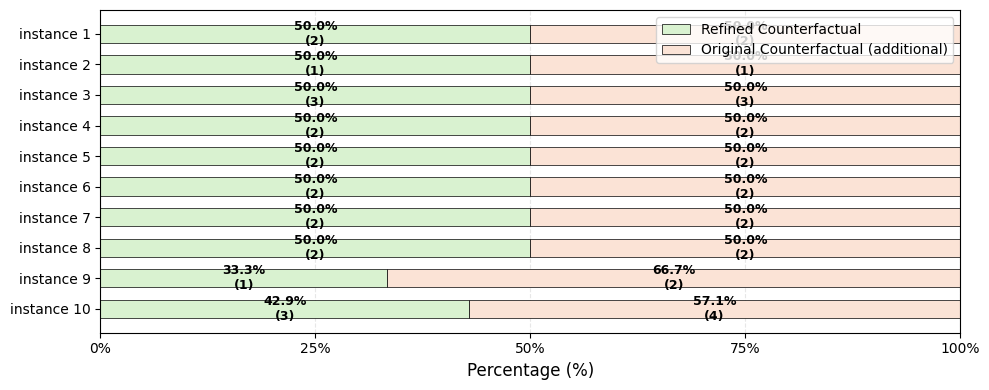

In [48]:
fig = sparsifier.stacked_bar_chart(save_path='./results')

##### 6.6 Diversity results via exhaustive search on refined counterfactuals

In [49]:
factual_df, diversity_styles = sparsifier.diversity()
for i, style in enumerate(diversity_styles):
    print(f"Instance {i+1} diversity:")
    display(style)

Instance 1 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,35,female,unskilled and resident,own,little,little,10722,14,business,0


Instance 2 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,55,female,skilled,own,quite rich,little,1603,24,radio/TV,0


Instance 3 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,58,female,unskilled and resident,own,little,little,6143,14,business,0


Instance 4 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,22,female,skilled,own,quite rich,moderate,5951,18,radio/TV,0
1,22,female,skilled,own,little,moderate,5951,18,radio/TV,0


Instance 5 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,45,male,skilled,own,little,little,7882,18,furniture/equipment,0


Instance 6 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,23,female,unskilled and non-resident,own,quite rich,little,3758,24,radio/TV,0
1,23,female,unskilled and non-resident,own,quite rich,moderate,3758,24,radio/TV,0


Instance 7 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,48,male,unskilled and non-resident,free,little,little,2241,10,car,0


Instance 8 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,36,male,unskilled and non-resident,rent,quite rich,moderate,6967,24,business,0
1,36,male,highly skilled,rent,quite rich,moderate,6967,24,business,0


Instance 9 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,34,male,skilled,own,little,little,6999,19,radio/TV,0


Instance 10 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,22,female,skilled,own,little,moderate,1835,17,radio/TV,0
1,25,female,skilled,own,little,moderate,1835,21,radio/TV,0
2,25,female,skilled,own,little,little,1835,17,radio/TV,0
